In [1]:
import os
import numpy as np
from glob import glob
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [2]:
class PASTISSegmentation:
    """
    Here we use a subset of the PASTIS dataset: https://github.com/VSainteuf/pastis-benchmark
    """
    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split:str = "train",
        median_of_days: bool = False,
        Xmean = None,
        Xstd = None,
        binary_labels: bool = False
    ) -> None:
        
        images = glob(os.path.join(image_dir, split, 'S2_*.npy'))
        annotations = []
        for im in images:
            name = os.path.splitext(os.path.basename(im))[0].replace("S2_", "")
            annotations.append(os.path.join(annotation_dir, split, f"TARGET_{name}.npy"))

        # Store in the class for future reference
        self.median_of_days = median_of_days
        self.binary_labels = binary_labels
        
        # Load data
        self.X = self.read_data(images)
        if median_of_days:
            self.X = np.median(self.X, axis=1) #Take median value across 43 days

        ### Normalization
        ### Using the provided values (Xmean, Xstd) we normalize the input X to have zero mean and unit variance
        if Xmean is not None and Xstd is not None:
            self.X = (self.X - Xmean) / Xstd
            
        self.y = self.read_data(annotations)
        self.y = self.y[:,0] # We are only interested in the 20 classes for now
        if binary_labels:
            self.y[self.y>0] = 1 # Convert to binary labels
        
    def __len__(self):
        return self.X.shape[0]
    
    def read_data(self, files):
        """
        Reads and stacks our data
        """
        t = []
        for im in files:
            t.append(np.load(im))
        return np.stack(t, axis=0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def pixelwise(self):
        """
        This method flattens our images to individual pixels, so we can treat
        each pixel as a sample and train our favirote classifier on it. 
        """
        if self.median_of_days:
            return  np.transpose(self.X, (0, 2, 3, 1)).reshape(-1, 10), self.y.reshape(-1)
        else:
            return  np.transpose(self.X, (0, 3, 4, 1, 2)).reshape(-1, 430), self.y.reshape(-1)
    
    def pixelwise_test(self):
        """
        Short test for the above method.
        """
        N = self.__len__()
        
        pX, py = self.pixelwise()
        if self.median_of_days:
            tX = np.transpose(pX.reshape(N, 128, 128, 10), (0, 3, 1, 2))    
        else:
            tX = np.transpose(pX.reshape(N, 128, 128, 43, 10), (0, 3, 4, 1, 2))
        tY = py.reshape(N, 128, 128)
        assert np.all(tX == self.X) and np.all(tY == self.y)
        print("All test passed!")

In [3]:
base_path = r"C:\Users\birgi\Desktop\Geoinformatics M.Sc\Big DAta\data_week4" # Define it

p_train = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="train",
                             median_of_days=True,
                             binary_labels=False)

p_test = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="test",
                            median_of_days=True,
                            binary_labels=False)
p_train.pixelwise_test()
p_test.pixelwise_test()

X_train, y_train = p_train.pixelwise()
X_test, y_test = p_test.pixelwise()

All test passed!
All test passed!


In [4]:
base_path = r"C:\Users\birgi\Desktop\Geoinformatics M.Sc\Big DAta\data_week4" # Define it

Xmean = np.array([ 596.57817383, 878.493514, 969.89764811, 1324.39628906, 2368.21767578, 2715.68257243, 2886.70323486, 2977.03915609, 2158.25386556, 1462.10965169])
Xmean = Xmean.reshape((1, 10, 1, 1))
Xstd = np.array([251.33337853, 289.95055489, 438.725014, 398.7289996, 706.53781626, 832.72503267, 898.14189979, 909.04165075, 661.66078257, 529.15340992])
Xstd = Xstd.reshape((1, 10, 1, 1))

p_train_norm = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="train",
                             median_of_days=True,
                             Xmean=Xmean,
                             Xstd=Xstd,
                             binary_labels=False)

p_test_norm = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="test",
                            median_of_days=True,
                            Xmean=Xmean,
                            Xstd=Xstd, 
                            binary_labels=False)
p_train_norm.pixelwise_test()
p_test_norm.pixelwise_test()

X_train_norm, y_train_norm = p_train_norm.pixelwise()
X_test_norm, y_test_norm = p_test_norm.pixelwise()


All test passed!
All test passed!


In [5]:
# Instead of images, we focus on the individual pixels. For each pixel, we have 10 features and a class (in y).
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((245760, 10), (245760,), (81920, 10), (81920,))

In [6]:
# The normalized data should have the same shape as above
X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape,

((245760, 10), (245760,), (81920, 10), (81920,))

In [7]:
# But the difference in values are strak!
print(np.mean(X_train), np.mean(X_train_norm))

#Normalisation sclaes data to be b etween 0 and 1

1833.737178141276 -2.5295228874474182e-14


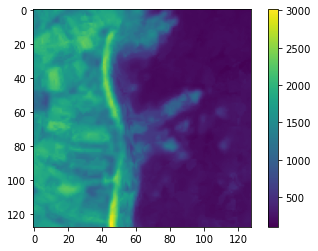

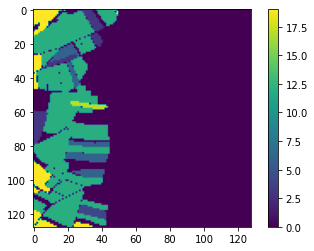

In [8]:
imd = 5
# Show the 3rd band of the third image
plt.imshow(p_train.X[imd, 3])
plt.colorbar()
plt.show()

# Show the labels for third image
plt.imshow(p_train.y[imd])
plt.colorbar()
plt.show()

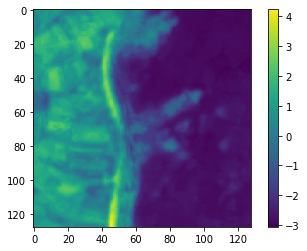

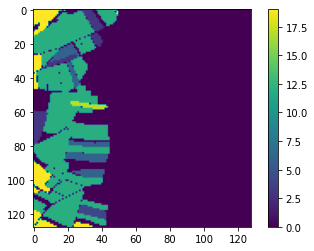

In [9]:
imd = 5
# Show the 3rd band of the third image
plt.imshow(p_train_norm.X[imd, 3])
plt.colorbar()
plt.show()

# Show the labels for third image
plt.imshow(p_train_norm.y[imd])
plt.colorbar()
plt.show()

# Feature importance and normalization in Logistic Regression

In [10]:
# Train a logistic regressor on the unnormalied data
logistic_regressor = sklearn.linear_model.LogisticRegression(n_jobs=-1, penalty='none', max_iter=100).fit(X_train, y_train)
print("Score:", logistic_regressor.score(X_test, y_test))

# Compute feature importance 
model_fi = permutation_importance(logistic_regressor, X_train, y_train)
print("Importance of the 10 features:", model_fi['importances_mean'])

Score: 0.35574951171875
Importance of the 10 features: [0.12009603 0.08084066 0.22889648 0.07252116 0.31980713 0.17536296
 0.1090804  0.10061686 0.11987305 0.18851807]


In [11]:
# Train a logistic regressor on the normalied data
logistic_regressor_norm = sklearn.linear_model.LogisticRegression(n_jobs=-1, penalty='none', max_iter=100).fit(X_train_norm, y_train_norm)
print("Score:", logistic_regressor_norm.score(X_train_norm, y_train_norm))

# Compute feature importance
model_fi_norm = permutation_importance(logistic_regressor_norm, X_train_norm, y_train_norm)
print("Importance of the 10 features:", model_fi_norm['importances_mean'])

Score: 0.58909912109375
Importance of the 10 features: [0.17927653 0.16647461 0.24336751 0.13454671 0.35098145 0.278479
 0.05534017 0.26674723 0.13083008 0.16067139]


In [12]:
# Train a logistic regressor on the unnormalied data for 1000 iterations
# This will take a long time!!!
logistic_regressor = sklearn.linear_model.LogisticRegression(n_jobs=-1, penalty='none', max_iter=1000).fit(X_train, y_train)
print("Score:", logistic_regressor.score(X_test, y_test))

# Compute feature importance 
model_fi = permutation_importance(logistic_regressor, X_train, y_train)
print("Importance of the 10 features:", model_fi['importances_mean'])

Score: 0.37784423828125
Importance of the 10 features: [0.1790096  0.15524577 0.23303874 0.1299943  0.35140869 0.33074382
 0.05124593 0.29268066 0.12754639 0.1814681 ]


When using the not normalised data, a warning indicats that the coeficents did not converge, meaning that the algo was not able to find a perfect set of weights withing the given iterations. This can  be caused by different scale between the features 

Gradient descent optimization: Many optimization algorithms, such as gradient descent, rely on the calculation of gradients to update the model parameters iteratively. Gradients are affected by the scale of the features. If the features have different scales, the gradients can vary widely, causing oscillations or slow convergence. Normalizing the features helps to mitigate this issue by providing a more consistent gradient landscape.


--> faster optimisation --> covergence

# Random Forest

In [13]:
# Fit a random forest
random_forest = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=0).fit(X_train, y_train)
print("Score:", random_forest.score(X_test, y_test))

print("Importance of the 10 features:", random_forest.feature_importances_)

Score: 0.42623291015625
Importance of the 10 features: [0.10614418 0.08717252 0.11719879 0.0917325  0.12433203 0.09006508
 0.08810778 0.08892012 0.11790989 0.08841713]


In [14]:
# Fit a random forest
random_forest_norm = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=0).fit(X_train_norm, y_train_norm)
print("Score:", random_forest_norm.score(X_test_norm, y_test_norm))
print("Importance of the 10 features:", random_forest_norm.feature_importances_)

Score: 0.42630615234375
Importance of the 10 features: [0.10614418 0.08717252 0.11719879 0.0917325  0.12433203 0.09006508
 0.08810778 0.08892012 0.11790989 0.08841713]


not relient on fitting of an optimal line but decision trees --> no coefficents that could not converge

to make s split it is not looked at how the error would behave, but on how much information is gained by looking at the distance form the point to the mean